# Toy Latent Variable Model
Consider a simple latent variable model where we have observations $y_1, \dots, y_n \in \mathbb{R}^d$ drawn from
    \begin{align*}
        z|\theta &\sim \mathcal{N}(\cdot;\theta \textsf{1}_d, \textsf{Id}_d)\\
        y|z &\sim \mathcal{N}(\cdot;z, \textsf{Id}_d)
    \end{align*}
    where $\theta\in\mathbb{R}$ and $\textsf{1}_d, \textsf{Id}_d$ denote the $d$-dimensional vector of ones and the $d\times d$ identity matrix respectively.

In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [2]:
D = 50  # Dimensionality of latent variables.
thdata = 1  # Parameter value used to generate the data.

# Generate the data:
y = np.random.normal(0, 1, (D, 1)) + np.random.normal(thdata, 1, (D, 1))

In [3]:
# get MLE
theta_mle = np.mean(y)
theta_mle

1.0473621717301405

## Adaptive step size

In [4]:
#Set approximation parameters:
Niter = 500  # Number of steps.
N = 500  # Number of particles.

th0 = np.array([0])  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [41]:
def next_gamma_md(current_gamma, alpha, logW):
    N = logW.shape[0]
    def f(e):
        ess = rs.essl(e * logW) if e > 0.0 else N  # avoid 0 x inf issue when e==0
        return ess - alpha * N
    if f(current_gamma)*f(1) < 0.:
        return optimize.brentq(f, current_gamma, 1.0)
    else:
        return 1.0

In [60]:
gamma = np.array([0])
Cn = np.array([1])
theta = np.array([])
n = -1
epsilon = 1e-5

In [61]:
while((Cn[n] > epsilon) & (n < Niter)):
    n = n+1
    if (n == 0):
        theta = np.append(theta, th0)
        x = np.random.normal(size = (N, D))
    else:
        Cn = np.append(Cn, np.prod(1-gamma[1:]))
#         theta = np.append(theta, theta[n-1] + gamma[n]*(np.sum(np.sum(x, axis = 1)*W)-D*theta[n-1]))
        theta = np.append(theta, theta_mle)
        # resample
        ancestors = rs.resampling('stratified', W)
        x = x[ancestors, :]
        # MCMC move
        prop = md_lvm.rwm_proposal(x, W)
        x = md_lvm.rwm_accept_toy_lvm(x, prop, theta[:n], gamma[:n], y)
    # reweight
    logW = md_lvm.ll_toy_lvm(theta[n], x, y) + 0.5*np.prod(1-gamma[:n])*np.sum(x**2, axis = 1)
    for k in range(n):
        logW = logW - gamma[k]*np.prod(1-gamma[k:n])*md_lvm.ll_toy_lvm(theta[k], x, y)
    new_l = next_gamma_md(gamma[n], 0.5, logW)
    gamma = np.append(gamma, new_l)
    logW = gamma[n+1]*logW
    W = rs.exp_and_normalise(logW)

LinAlgError: 7-th leading minor of the array is not positive definite

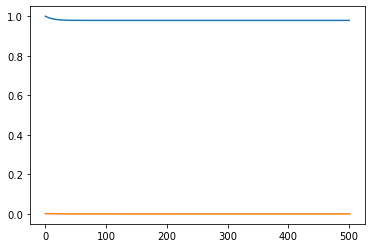

In [52]:
# plt.yscale("log")
plt.plot(Cn)
plt.plot(gamma)

In [62]:
gamma

array([0.        , 0.08204945, 1.        ])

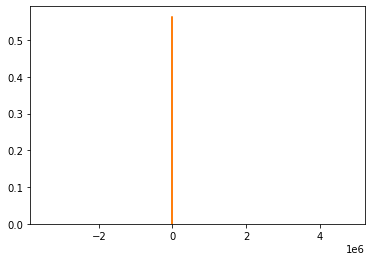

In [54]:
plt.hist(x[:, 0], density = True, bins = 50, weights = W, label='MD');
plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100), scale = np.sqrt(0.5), loc = 0.5*(np.mean(y)+1)))
# plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100)))

(0.0, 500.0)

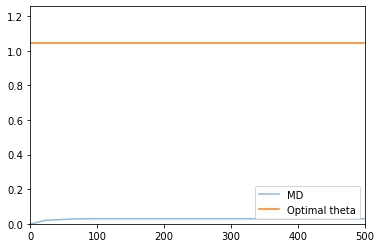

In [55]:
plt.plot(theta, label='MD', alpha = 0.5)
plt.plot(y.mean()*np.ones(Niter), label='Optimal theta')
plt.legend(loc='lower right')
plt.ylim([0, 1.2*y.mean()])
plt.xlim([0, Niter])
# plt.savefig('toy_optimal_gamma.pdf', bbox_inches="tight")

In [34]:
theta

array([0.        , 0.00631077, 0.01876765, 0.04018923, 0.07233937,
       0.11644211, 0.18654208, 0.30577744, 0.42801766, 0.48199474,
       0.50456706, 0.51353216, 0.51290015])